In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os, glob, inspect, sys
from sklearn import metrics
from scipy.cluster.hierarchy import fcluster

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib' from 'C:\\Users\\Saad J\\Desktop\\epri\\myepri\\MC\\nb\\epri_mc_lib.py'>

In [3]:
data_path = "../../Data/Merged"
df = pd.read_csv(os.path.join(data_path, 'ALL_TUBE_PIPE_merge_1.csv'), 
                 index_col=0)
df.head()

,TEP_mean_uV_C,TEP_error_uV_C,Absorption_avg_500,Absorption_std_500,backscatter_avg,backscatter_std,Absorption_avg_50,Absorption_std_50,A,A std,...,std_MBN,median_CF_g,mean_CF_g,std_CF_g,median_perm_g,mean_perm_g,std_perm_g,median_pMBN_g,mean_pMBN_g,std_pMBN_g
T_B1,12.947951,0.073112,0.000234,0.000018,0.0175,0.0042,0.001264,0.000519,4.410000e-13,4.090000e-07,...,0.127282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T_B2,12.920068,0.077814,0.000571,0.000139,0.0240,0.0057,0.002486,0.000816,1.520000e-06,1.510000e-06,...,0.110443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T_B3,12.932865,0.088762,0.000244,0.000030,0.0134,0.0028,0.001168,0.000555,4.270000e-13,5.640000e-07,...,0.178157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T_B4,10.763517,0.071173,0.000379,0.000100,0.0146,0.0031,0.002084,0.000648,7.580000e-07,1.000000e-06,...,0.052547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T_B5,12.942958,0.074808,0.000230,0.000033,0.0182,0.0040,0.001141,0.000447,3.970000e-13,4.670000e-07,...,0.042655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Selecting subsample


In [4]:
df=df.iloc[:16] # choosing tube specimen data only
df.dropna(axis=1, inplace=True) # drop all nan columns

In [5]:
CV_list=df[['TEP_mean_uV_C',
 'TEP_error_uV_C',
 'backscatter_avg',
 'backscatter_std',
 'Absorption_avg_50',
 'Absorption_std_50',
 'A',
 'A std',
 'B',
 'B std',
 'p',
 'p std',
 'Absorption_avg_100',
 'Absorption_std_100',
 'mean_CF',
 'std_CF',
 'mean_perm',
 'std_perm']].copy()
CV_list

,TEP_mean_uV_C,TEP_error_uV_C,backscatter_avg,backscatter_std,Absorption_avg_50,Absorption_std_50,A,A std,B,B std,p,p std,Absorption_avg_100,Absorption_std_100,mean_CF,std_CF,mean_perm,std_perm
T_B1,12.947951,0.073112,0.0175,0.0042,0.001264,0.000519,4.410000e-13,4.090000e-07,0.000875,0.000218,0.219,0.0247,0.000682,0.000193,1.100636,0.013418,68.300000,1.115347
T_B2,12.920068,0.077814,0.0240,0.0057,0.002486,0.000816,1.520000e-06,1.510000e-06,0.002010,0.000802,0.273,0.0908,0.001069,0.000365,1.107818,0.015721,66.336364,0.890250
T_B3,12.932865,0.088762,0.0134,0.0028,0.001168,0.000555,4.270000e-13,5.640000e-07,0.000799,0.000300,0.218,0.0340,0.000658,0.000246,1.079909,0.016489,68.390909,0.770006
T_B4,10.763517,0.071173,0.0146,0.0031,0.002084,0.000648,7.580000e-07,1.000000e-06,0.001210,0.000535,0.299,0.0605,0.000921,0.000223,4.509000,0.032860,32.909091,0.434637
T_B5,12.942958,0.074808,0.0182,0.0040,0.001141,0.000447,3.970000e-13,4.670000e-07,0.000890,0.000249,0.245,0.0282,0.000571,0.000113,1.432636,0.017591,65.200000,1.173882
T_B6,11.037827,0.090636,0.0148,0.0031,0.001323,0.000574,1.350000e-12,3.500000e-07,0.000541,0.000187,0.209,0.0211,0.000818,0.000345,4.704636,0.068887,33.936364,0.881218
T_B7,12.882150,0.099066,0.0300,0.0087,0.001908,0.000926,4.820000e-13,1.250000e-06,0.002440,0.000665,0.495,0.0752,0.001014,0.000335,0.678818,0.059461,100.081818,6.020103
T_B8,12.257788,0.080920,0.0269,0.0062,0.000933,0.000304,4.420000e-12,4.410000e-07,0.000972,0.000235,0.247,0.0266,0.000617,0.000174,2.101455,0.372001,57.127273,3.940835
T_AR,12.947031,0.089787,0.0179,0.0038,0.001257,0.000210,4.430000e-13,5.060000e-07,0.000851,0.000270,0.203,0.0305,0.000982,0.000325,1.236364,0.028040,61.981818,0.435473
T_N,10.805126,0.076842,0.0253,0.0054,0.003128,0.001147,1.440000e-07,1.730000e-06,0.001480,0.000921,0.288,0.1040,0.000959,0.000175,4.503364,0.032598,33.290909,0.291392


In [6]:
CV_list.columns.tolist()

['TEP_mean_uV_C',
 'TEP_error_uV_C',
 'backscatter_avg',
 'backscatter_std',
 'Absorption_avg_50',
 'Absorption_std_50',
 'A',
 'A std',
 'B',
 'B std',
 'p',
 'p std',
 'Absorption_avg_100',
 'Absorption_std_100',
 'mean_CF',
 'std_CF',
 'mean_perm',
 'std_perm']

In [7]:
CV_list.shape

(16, 18)

In [8]:
def scale_general(df, scaler):
    ''' Scale a dataframe using a given scaler (fit and transform).
        Keeps index and column names.
        Return new dataframe, scaler.
        
        Args:
        - df : pandas dataframe
        - scaler : initialized sklearn scaler function
        
        return scaled df and fit scaler
    '''
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    return df_scaled, scaler

In [9]:
def plot_corr(data):
    '''
    Plot correlation 
    Args:
    - data: pd dataframe
    '''
    corr = data.corr()
    sns.set(font_scale=1.2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(12, 10))
        ax = sns.heatmap(corr, mask=mask, square=True, cmap='RdBu_r', center=0, annot=True)

## Calculating ther coefficient of variation CV

In [10]:
CV_list['TEP_uV_C_CV']=CV_list['TEP_error_uV_C']/CV_list['TEP_mean_uV_C']
CV_list['bkstr_CV']=CV_list['backscatter_std']/CV_list['backscatter_avg']
CV_list['absp_50_CV']=CV_list['Absorption_std_50']/CV_list['Absorption_avg_50']
CV_list['A_CV']=CV_list['A std']/CV_list['A']
CV_list['B_CV']=CV_list['B std']/CV_list['B']
CV_list['p_CV']=CV_list['p std']/CV_list['p']
CV_list['absp_100_CV']=CV_list['Absorption_std_100']/CV_list['Absorption_avg_100']
CV_list['CF_CV']=CV_list['std_CF']/CV_list['mean_CF']
CV_list['perm_CV']=CV_list['std_perm']/CV_list['mean_perm']

# we also drop the old feature columns
CV_list.drop(['TEP_error_uV_C','TEP_mean_uV_C'
              ,'backscatter_avg', 'backscatter_std','Absorption_avg_50','Absorption_std_50','A','A std','B',
              'B std','p','p std', 'Absorption_avg_100', 'Absorption_std_100', 'mean_CF', 'std_CF', 'mean_perm',
              'std_perm'],axis=1, inplace=True)

In [11]:
CV_list.columns.tolist()

['TEP_uV_C_CV',
 'bkstr_CV',
 'absp_50_CV',
 'A_CV',
 'B_CV',
 'p_CV',
 'absp_100_CV',
 'CF_CV',
 'perm_CV']

In [12]:
CV_list

,TEP_uV_C_CV,bkstr_CV,absp_50_CV,A_CV,B_CV,p_CV,absp_100_CV,CF_CV,perm_CV
T_B1,0.005647,0.240000,0.410918,9.274376e+05,0.249143,0.112785,0.282717,0.012192,0.016330
T_B2,0.006023,0.237500,0.328077,9.934211e-01,0.399005,0.332601,0.340877,0.014191,0.013420
T_B3,0.006863,0.208955,0.475514,1.320843e+06,0.375469,0.155963,0.373348,0.015269,0.011259
T_B4,0.006612,0.212329,0.310940,1.319261e+00,0.442149,0.202341,0.242289,0.007288,0.013207
T_B5,0.005780,0.219780,0.392200,1.176322e+06,0.279775,0.115102,0.198634,0.012279,0.018004
T_B6,0.008211,0.209459,0.434165,2.592593e+05,0.345656,0.100957,0.421516,0.014642,0.025967
T_B7,0.007690,0.290000,0.485377,2.593361e+06,0.272541,0.151919,0.330110,0.087594,0.060152
T_B8,0.006601,0.230483,0.325402,9.977376e+04,0.241770,0.107692,0.282679,0.177021,0.068983
T_AR,0.006935,0.212291,0.166826,1.142212e+06,0.317274,0.150246,0.331230,0.022680,0.007026
T_N,0.007112,0.213439,0.366720,1.201389e+01,0.622297,0.361111,0.182890,0.007239,0.008753


## Check correlation between features

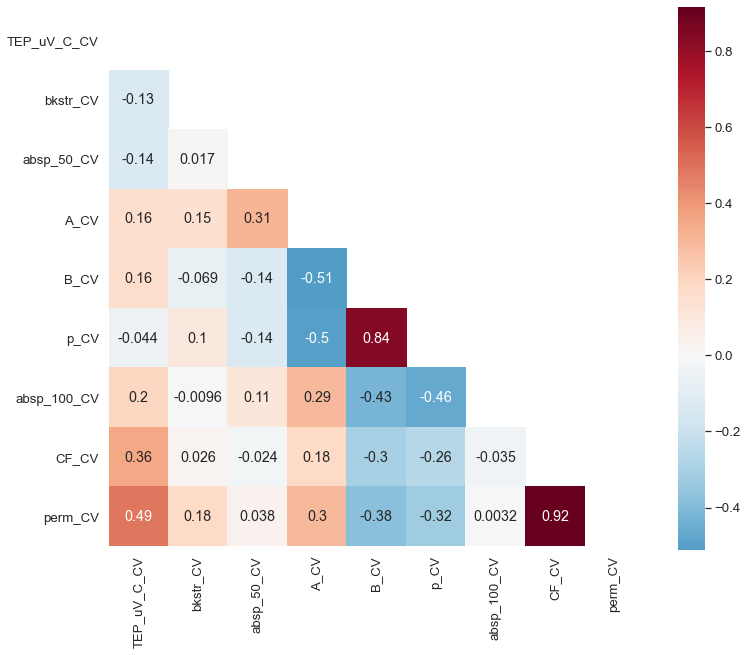

In [13]:
plot_corr(CV_list)

#### We observe high correlation between some features, divide one by the other

In [14]:
CV_list['CF_perm_CV'] = CV_list['CF_CV']/CV_list['perm_CV']
CV_list['B_p_CV'] = CV_list['B_CV']/CV_list['p_CV']

# we also drop the existing features
CV_list.drop(['CF_CV', 'B_CV','p_CV','perm_CV'], axis=1, inplace=True)

In [15]:
CV_list.columns.tolist()

['TEP_uV_C_CV',
 'bkstr_CV',
 'absp_50_CV',
 'A_CV',
 'absp_100_CV',
 'CF_perm_CV',
 'B_p_CV']

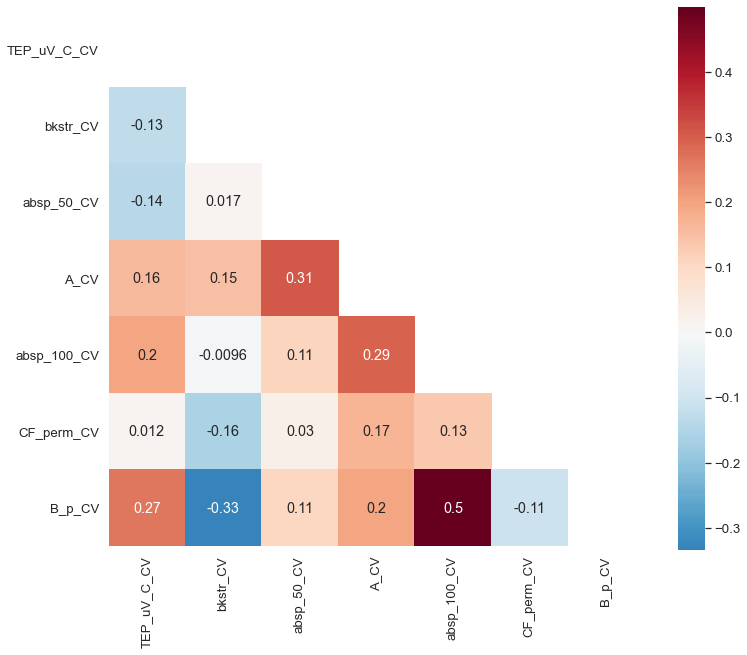

In [16]:
plot_corr(CV_list)

## Scaling the data using MinMaxScaler

In [17]:
CV_list_scaled = mc.scale_general(CV_list, MinMaxScaler())[0]
CV_list_scaled

,TEP_uV_C_CV,bkstr_CV,absp_50_CV,A_CV,absp_100_CV,CF_perm_CV,B_p_CV
T_B1,0.009713,0.327655,0.650892,3.576198e-01,0.418342,0.083280,0.453814
T_B2,0.154943,0.301269,0.429991,1.446245e-07,0.662071,0.165221,0.000000
T_B3,0.479495,0.000000,0.823142,5.093170e-01,0.798143,0.243952,0.543026
T_B4,0.382635,0.035605,0.384294,2.702685e-07,0.248923,0.031945,0.443097
T_B5,0.061147,0.114250,0.600979,4.535898e-01,0.065977,0.066262,0.553480
T_B6,1.000000,0.005322,0.712882,9.997016e-02,1.000000,0.035132,1.000000
T_B7,0.798756,0.855368,0.849445,1.000000e+00,0.616951,0.270322,0.267219
T_B8,0.378411,0.227213,0.422857,3.847253e-02,0.418183,0.562861,0.470001
T_AR,0.507149,0.035201,0.000000,4.404369e-01,0.621641,0.737319,0.410063
T_N,0.575380,0.047320,0.533035,4.394118e-06,0.000000,0.104480,0.235431


## Hierarchical Clustering 

#### Algorithm Description
1. Calculate distance between objects using pdist function
2. Use linkage function to link pairs of objects that are in close proximity, build hierarchical cluster tree
3. Determining the cut-off in the hierarchical tree 


In [18]:
X=CV_list_scaled.copy()

#### Names of models using different metric and method for each model

In [19]:
Y1=pdist(X, 'euclidean')
Z1=linkage(Y1, 'ward')

Y2=pdist(X, 'euclidean')
Z2=linkage(Y2, 'single')

Y3=pdist(X, 'euclidean')
Z3=linkage(Y3, 'average')

Y4=pdist(X, 'cityblock')
Z4=linkage(Y4, 'average')

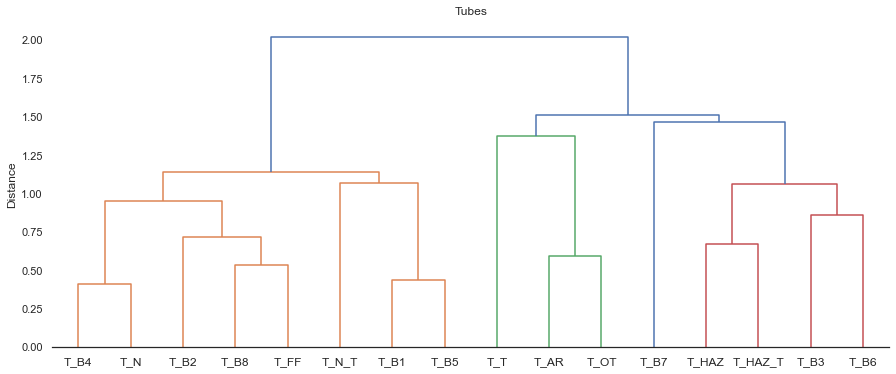

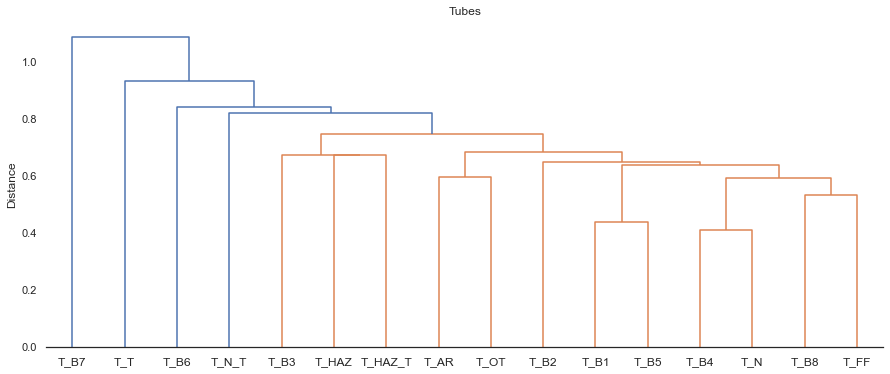

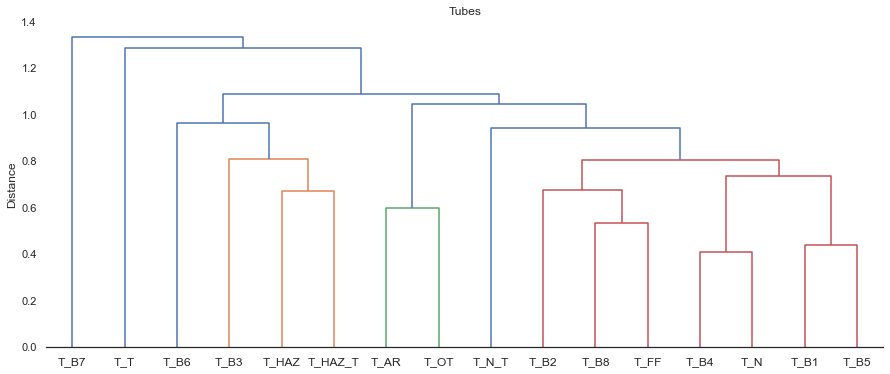

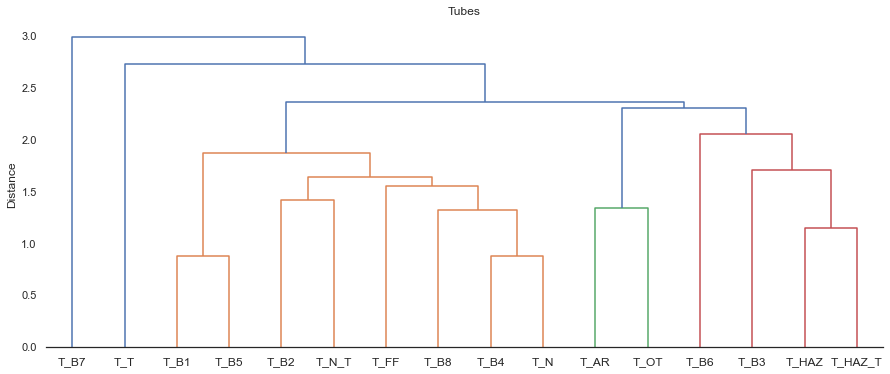

In [20]:
sns.set_theme(style="white")            

fig= plt.figure(figsize=(15, 6))
dn = dendrogram(Z1, labels=X.index)
sns.despine(left=True)
plt.ylabel('Distance')
plt.title('Tubes')


fig= plt.figure(figsize=(15, 6))
dn = dendrogram(Z2,labels=X.index)
sns.despine(left=True)
plt.ylabel('Distance')
plt.title('Tubes')
                

fig= plt.figure(figsize=(15, 6))
dn = dendrogram(Z3,labels=X.index)
sns.despine(left=True)
plt.ylabel('Distance')
plt.title('Tubes')
                

fig= plt.figure(figsize=(15, 6))
dn = dendrogram(Z4,labels=X.index)
sns.despine(left=True)                
plt.ylabel('Distance')
plt.title('Tubes')

plt.show()

### Verifying the cluster tree

#### Verifying dissimilarity using cophenetic correlation coefficient



In [21]:
c1, ccc_eu_ward = hierarchy.cophenet(Z1, Y1)
c2, ccc_eu_single = hierarchy.cophenet(Z2, Y2)
c3, ccc_eu_average = hierarchy.cophenet(Z3, Y3)
c4, ccc_cb_average = hierarchy.cophenet(Z4, Y4)

print("ccc_eu_ward :", c1)
print("ccc_eu_single :", c2)
print("ccc_eu_average :", c3)
print("ccc_cb_average :", c4)

ccc_eu_ward : 0.5695493978674917
ccc_eu_single : 0.7379226390251201
ccc_eu_average : 0.7646167644464765
ccc_cb_average : 0.7377177310881174


#### The highest ccc is for using eu_avg, it is the most representable linkage dendrogram of our pdist data

### Verifying Consistency
we can determine the natural cluster division in a dataset is to compare the height of a link to its neighbouring links below it in the tree.
This helps to indicate the distinction between division in the tree. A link with high consistency is said to have a its distance approximately the same as the distance of the objects it contains (the links below in the tree). On the other hand, a link with high inconsistency is said to have a distance whose link differs noticably from the links below it. Hence a high inconsistency indicates that the link joined above the leaf nodes is farther apart from the joined objects. 

The inconsistent coefficient is a quantified expression of the relative consistency of each link. The lead nodes (bottom object) has a zero inconsistency coefficient. 

"This value compares
the height of a link in a cluster hierarchy with the average height of links
below it. Links that join distinct clusters have a high inconsistency coefficient;
links that join indistinct clusters have a low inconsistency coefficient." (http://cda.psych.uiuc.edu/multivariate_fall_2013/matlab_help/cluster_analysis.pdf)

Column Description of the inconsistency matrix

1 Mean of the heights of all the links included in the calculation

2 Standard deviation of all the links included in the calculation

3 Number of links included in the calculation

4 Inconsistency coefficient

In [23]:
#d is optional  depth of the comparison chooses how many levels below a link to compare
#incons = hierarchy.inconsistent(Z, d)

Z1_incons = hierarchy.inconsistent(Z1)
Z2_incons = hierarchy.inconsistent(Z2)
Z3_incons = hierarchy.inconsistent(Z3)
Z4_incons = hierarchy.inconsistent(Z4)

In [24]:
print("Z1_inconsistency :\n", Z1_incons)

print("\nZ2_inconsistency :\n", Z2_incons)

print("\nZ3_inconsistency :\n", Z3_incons)

print("\nZ4_inconsistency :\n", Z4_incons)

Z1_inconsistency :
 [[0.4120199  0.         1.         0.        ]
 [0.44076349 0.         1.         0.        ]
 [0.53463637 0.         1.         0.        ]
 [0.59721145 0.         1.         0.        ]
 [0.67243157 0.         1.         0.        ]
 [0.62675298 0.13027256 2.         0.70710678]
 [0.86246931 0.         1.         0.        ]
 [0.69453654 0.27117016 3.         0.95210914]
 [0.86663663 0.19632189 3.         1.01044449]
 [0.75643458 0.44642633 2.         0.70710678]
 [1.05674582 0.0972597  3.         0.91164005]
 [0.98741399 0.55182972 2.         0.70710678]
 [1.26763677 0.28655894 2.         0.70710678]
 [1.45296251 0.06835743 3.         0.84912422]
 [1.56012937 0.44133431 3.         1.05099604]]

Z2_inconsistency :
 [[4.12019904e-01 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [4.40763494e-01 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [5.34636373e-01 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [5.13020179e-01 9.21144606e-02 3.00000000e+00 8.61798253e-01]
 

#### Finding natural divisions in data using the inconsistency coefficient to try find the cut-off the line. 

In [27]:
#this returns a list with highest t (inconsistency coefficient), max number of cluster for the t and depth
def inconsistency(linkage_matrix, CV_list_scaled, method):
    for depth in np.arange(0,6):
        incons = hierarchy.inconsistent(linkage_matrix, depth)
        max_inc = hierarchy.maxinconsts(linkage_matrix, incons)
        for t in np.unique(np.around(max_inc, 2)):
            cluster = hierarchy.fclusterdata(CV_list_scaled, t=t, method=method)
            print('depth:', depth, ': ', 't=', t, ' cluster = ', int(cluster.max()))

In [28]:
Z3_incons=inconsistency(Z3, CV_list_scaled, 'average')
Z3_incons

depth: 0 :  t= 0.0  cluster =  11
depth: 1 :  t= 0.0  cluster =  11
depth: 2 :  t= 0.0  cluster =  11
depth: 2 :  t= 0.71  cluster =  8
depth: 2 :  t= 1.15  cluster =  8
depth: 3 :  t= 0.0  cluster =  11
depth: 3 :  t= 0.71  cluster =  8
depth: 3 :  t= 1.02  cluster =  8
depth: 3 :  t= 1.15  cluster =  8
depth: 3 :  t= 1.26  cluster =  1
depth: 3 :  t= 1.32  cluster =  1
depth: 3 :  t= 1.39  cluster =  1
depth: 4 :  t= 0.0  cluster =  11
depth: 4 :  t= 0.71  cluster =  8
depth: 4 :  t= 1.02  cluster =  8
depth: 4 :  t= 1.15  cluster =  8
depth: 4 :  t= 1.26  cluster =  1
depth: 4 :  t= 1.48  cluster =  1
depth: 4 :  t= 1.49  cluster =  1
depth: 5 :  t= 0.0  cluster =  11
depth: 5 :  t= 0.71  cluster =  8
depth: 5 :  t= 1.02  cluster =  8
depth: 5 :  t= 1.15  cluster =  8
depth: 5 :  t= 1.26  cluster =  1
depth: 5 :  t= 1.48  cluster =  1
depth: 5 :  t= 1.65  cluster =  1
depth: 5 :  t= 1.74  cluster =  1


In [29]:
Z4_incons=inconsistency(Z4, CV_list_scaled, 'average')
Z4_incons

depth: 0 :  t= 0.0  cluster =  11
depth: 1 :  t= 0.0  cluster =  11
depth: 2 :  t= 0.0  cluster =  11
depth: 2 :  t= 0.71  cluster =  8
depth: 2 :  t= 0.8  cluster =  8
depth: 2 :  t= 0.93  cluster =  8
depth: 3 :  t= 0.0  cluster =  11
depth: 3 :  t= 0.71  cluster =  8
depth: 3 :  t= 0.89  cluster =  8
depth: 3 :  t= 0.92  cluster =  8
depth: 3 :  t= 1.07  cluster =  8
depth: 3 :  t= 1.12  cluster =  8
depth: 3 :  t= 1.17  cluster =  1
depth: 4 :  t= 0.0  cluster =  11
depth: 4 :  t= 0.71  cluster =  8
depth: 4 :  t= 0.89  cluster =  8
depth: 4 :  t= 0.92  cluster =  8
depth: 4 :  t= 0.95  cluster =  8
depth: 4 :  t= 1.23  cluster =  1
depth: 4 :  t= 1.26  cluster =  1
depth: 4 :  t= 1.43  cluster =  1
depth: 5 :  t= 0.0  cluster =  11
depth: 5 :  t= 0.71  cluster =  8
depth: 5 :  t= 0.89  cluster =  8
depth: 5 :  t= 0.92  cluster =  8
depth: 5 :  t= 0.95  cluster =  8
depth: 5 :  t= 1.23  cluster =  1
depth: 5 :  t= 1.35  cluster =  1
depth: 5 :  t= 1.62  cluster =  1
depth: 5 :  t= 

#### Our highest level of inconsistency coefficient is 1.15104191 as observed by Z3_inconsistency array above, hence why t=1.26 creates one cluster. And for t=0 we get 11 cluster, t=0.71 we get 8 clusters. That seems to be the optimal the model can generate in terms of distinction based on inconsistency coefficient.

Below is a df grouping each specimen with its corresponding group in cluster value

In [30]:
Z3_inconsistent_fcluster=fcluster(Z3, t=0.71, criterion='inconsistent')
Z3_inconsistent_fcluster=pd.DataFrame(Z3_inconsistent_fcluster, index=X.index)
Z3_inconsistent_fcluster.columns=['Cluster_incons']
Z3_inconsistent_fcluster.sort_values(by=['Cluster_incons'])

,Cluster_incons
T_B3,1
T_B6,1
T_HAZ,1
T_HAZ_T,1
T_AR,2
T_OT,2
T_B2,3
T_B8,3
T_FF,3
T_B4,4


### Elbow method
Probably the most well known method, the elbow method, in which the sum of squares at each number of clusters is calculated and graphed, and the user looks for a change of slope from steep to shallow (an elbow) to determine the optimal number of clusters. This method is inexact, but still potentially helpful.

Note, this method is inexact. And from the below results i does not seem to be clear if the elbow position is at 6 or 8. Use 6 based on observation judgement.

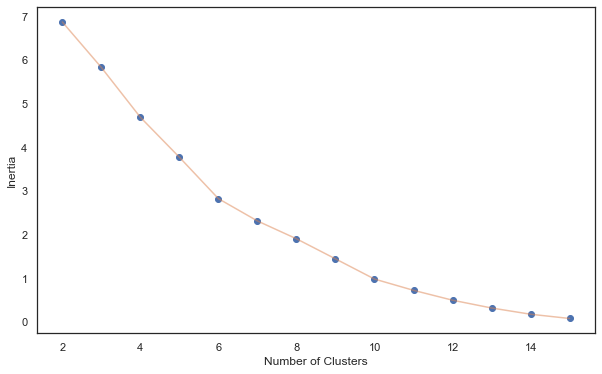

In [31]:
min_range = 2
max_range = 15

inertia = []
k_list = range(min_range, max_range+1)

for k in k_list:
    km = KMeans(n_clusters = k, random_state= 0)
    km.fit(X) 
    score = km.inertia_
    inertia.append(score)


plt.figure(1 , figsize = (10 ,6))
plt.plot(np.arange(min_range , max_range+1) , inertia , 'o')
plt.plot(np.arange(min_range , max_range+1) , inertia , '-' , alpha = 0.5)

plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

### Specifying Arbitrary Clusters
#### Cut off line at 6 clusters based on elbow method using maxclust method

In [32]:
Z3_maxclust_fcluster=fcluster(Z3, t=6, criterion='maxclust')
Z3_maxclust_fcluster=pd.DataFrame(Z3_maxclust_fcluster, index=X.index)
Z3_maxclust_fcluster.columns=['Cluster_maxclust']
Z3_maxclust_fcluster.sort_values(by=['Cluster_maxclust'])

,Cluster_maxclust
T_B3,1
T_HAZ,1
T_HAZ_T,1
T_B6,2
T_AR,3
T_OT,3
T_B1,4
T_B2,4
T_B4,4
T_B5,4


#### Cut-off line by observation for 'Euclidean Average' model of the dendrogram using distance as the criterion for fcluster function at 0.9 distance height as seen below - 0.9 is the observed distance value by judgement

Text(0.5, 1.0, 'Tubes')

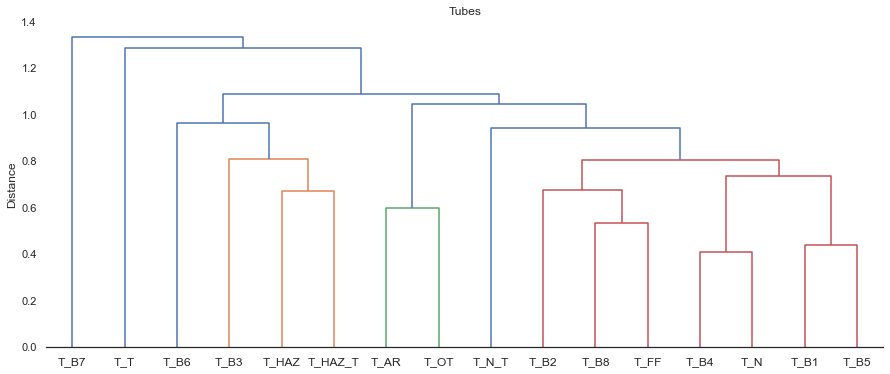

In [38]:
sns.set_theme(style="white")            
                

fig= plt.figure(figsize=(15, 6))
dn = dendrogram(Z3,labels=X.index)
sns.despine(left=True)
plt.ylabel('Distance')
plt.title('Tubes')

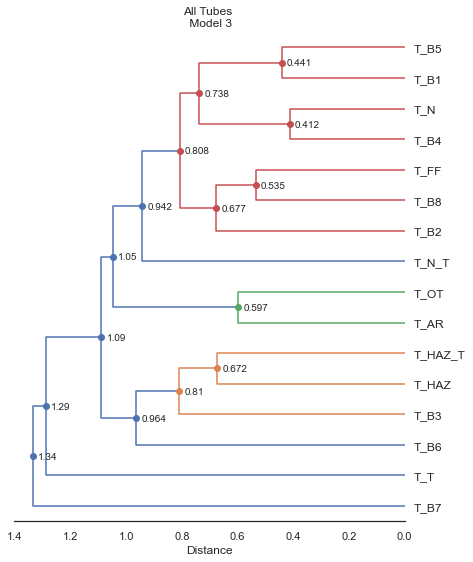

In [39]:


ax, fig = plt.subplots(figsize=(7,9))


dendro = hierarchy.dendrogram(Z3, labels=X.index, leaf_rotation=0, orientation='left',
                         color_threshold=0.9)

for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
    y = 0.5 * sum(i[1:3])
    x = d[1]
    plt.plot(x, y, 'o', c=c)
    plt.annotate('%.3g'%x, (x, y), xytext=(5, -5),
                 textcoords = 'offset points',
                 va='bottom', ha='left',
                 fontsize=10
                )


plt.xlabel('Distance')
plt.title('All Tubes \n Model 3')
sns.despine(left=True)

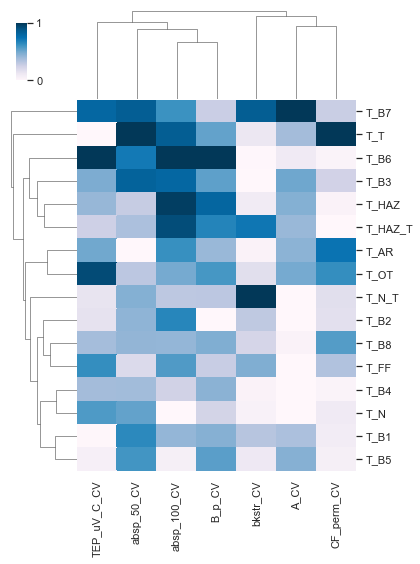

In [40]:
sns.clustermap(CV_list_scaled, method='average', metric='euclidean', cmap='PuBu', figsize=(6,8), dendrogram_ratio=(0.2, 0.2), cbar_pos=(0.05, 0.85, 0.025, 0.1))

#### For the 'Cityblock Average' model it is more difficult to guess the cut-off line by judging the dendrogram tree

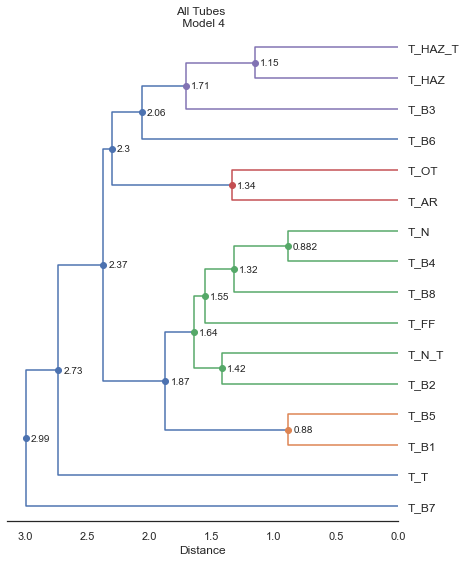

In [45]:


ax, fig = plt.subplots(figsize=(7,9))


dendro = hierarchy.dendrogram(Z4, labels=X.index, leaf_rotation=0, orientation='left',
                         color_threshold=1.8)

for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
    y = 0.5 * sum(i[1:3])
    x = d[1]
    plt.plot(x, y, 'o', c=c)
    plt.annotate('%.3g'%x, (x, y), xytext=(5, -5),
                 textcoords = 'offset points',
                 va='bottom', ha='left',
                 fontsize=10
                )


plt.xlabel('Distance')
plt.title('All Tubes \n Model 4')
sns.despine(left=True)

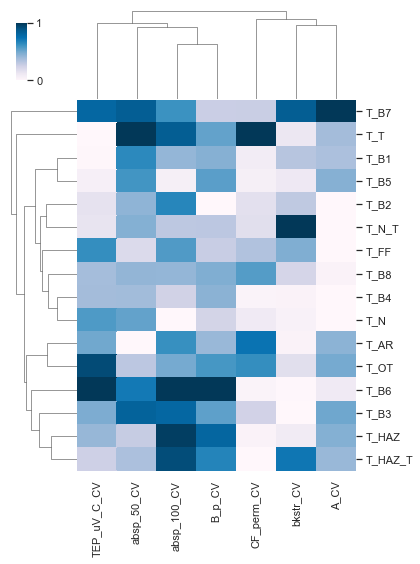

In [46]:
sns.clustermap(CV_list_scaled, method='average', metric='cityblock', cmap='PuBu', figsize=(6,8), dendrogram_ratio=(0.2, 0.2), cbar_pos=(0.05, 0.85, 0.025, 0.1))

#### Clustering group for 'Euclidean Average'

In [47]:
Z3_distance_fcluster=fcluster(Z3, t=0.9, criterion='distance')
Z3_distance_fcluster=pd.DataFrame(Z3_distance_fcluster, index=X.index)
Z3_distance_fcluster.columns=['Cluster_distance']
Z3_distance_fcluster.sort_values(by=['Cluster_distance'])

,Cluster_distance
T_B3,1
T_HAZ,1
T_HAZ_T,1
T_B6,2
T_AR,3
T_OT,3
T_B1,4
T_B2,4
T_B4,4
T_B5,4


In [48]:
#### Making one dataframe with all the clusters using different criterion
df_clusters=pd.DataFrame([Z3_inconsistent_fcluster['Cluster_incons'],Z3_maxclust_fcluster['Cluster_maxclust'],Z3_distance_fcluster['Cluster_distance']])
df_clusters

,T_B1,T_B2,T_B3,T_B4,T_B5,T_B6,T_B7,T_B8,T_AR,T_N,T_N_T,T_T,T_OT,T_FF,T_HAZ,T_HAZ_T
Cluster_incons,5,3,1,4,5,1,8,3,2,4,6,7,2,3,1,1
Cluster_maxclust,4,4,1,4,4,2,6,4,3,4,4,5,3,4,1,1
Cluster_distance,4,4,1,4,4,2,7,4,3,4,5,6,3,4,1,1


In [49]:
df_clusters=df_clusters.transpose()

# 

In [50]:
df_clusters.sort_values(by=['Cluster_distance'])

,Cluster_incons,Cluster_maxclust,Cluster_distance
T_B3,1,1,1
T_HAZ,1,1,1
T_HAZ_T,1,1,1
T_B6,1,2,2
T_AR,2,3,3
T_OT,2,3,3
T_B1,5,4,4
T_B2,3,4,4
T_B4,4,4,4
T_B5,5,4,4


# 

## 

# 